# k-Nearest Neighbor (kNN) Imputation

Implementation of k-Nearest Neighbor imputation for missing value estimation.

# k-Nearest Neighbor (kNN) Imputation

What we do in this notebook:
1. Create a dataset with controlled missing values
2. Implement kNN imputation using scikit-learn
3. Compare with distribution-based methods
4. Evaluate performance with RMSE and MAE
5. Visualize imputation quality

## Imports / setup


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# plotting style
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 120


## Config (paths and parameters)
- `input_file_ms`: path to the mass spec toy dataset (tab-separated, `NA` for missing)
- `ctrl_cols`: the three control columns to use for kNN
- `n_neighbors`, `weights`: kNN parameters
- `hist_bins`: number of bins for the histogram


In [20]:
input_file_ms = "../data/ms_toy.txt"
ctrl_cols = ["ctrl.1", "ctrl.2", "ctrl.3"]

# kNN parameters (simple, no over-engineering)
n_neighbors = 9
weights = "distance"  # or "uniform"

hist_bins = 60


## Load dataset and create the control-only table
- Read the file (tab-separated, `NA` as missing)
- Keep only `ctrl.1`, `ctrl.2`, `ctrl.3`
- Drop rows where **all three** controls are missing


In [21]:
# load
ms_data = pd.read_csv(input_file_ms, sep="\t", header=0, na_values=["NA"]) 
print("full data shape:", ms_data.shape)

# subset controls
ms_ctrl = ms_data[ctrl_cols].copy()
print("controls shape (before drop-all-NA):", ms_ctrl.shape)

# drop rows where all three controls are NA
ms_ctrl_nonallna = ms_ctrl.dropna(how="all", subset=ctrl_cols)
print("controls shape (after drop-all-NA):", ms_ctrl_nonallna.shape)

# show NA counts per control column (post-filter)
print("missing values per control column (after drop-all-NA):\n", ms_ctrl_nonallna.isna().sum())
ms_ctrl_nonallna.head()


full data shape: (6960, 6)
controls shape (before drop-all-NA): (6960, 3)
controls shape (after drop-all-NA): (6733, 3)
missing values per control column (after drop-all-NA):
 ctrl.1    360
ctrl.2    213
ctrl.3    147
dtype: int64


,ctrl.1,ctrl.2,ctrl.3
0,25.495032,26.226134,25.696122
1,32.432286,32.281099,32.305630
2,31.099802,30.957954,31.130075
3,NaN,23.817436,NaN
4,NaN,NaN,23.769814


## kNN imputation on the three control columns
We impute all remaining missing values in `ctrl.1`, `ctrl.2`, `ctrl.3` using `KNNImputer`.


In [22]:
# track which entries of ctrl.1 were NA (to overlay them in red later)
ctrl1_na_mask = ms_ctrl_nonallna["ctrl.1"].isna()

# fit/transform
imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights)
imputed_array = imputer.fit_transform(ms_ctrl_nonallna.values)
imputed_ctrl_df = pd.DataFrame(imputed_array, columns=ctrl_cols, index=ms_ctrl_nonallna.index)

# sanity check: no NA should remain in the three controls for kept rows
print("remaining NAs after kNN (should be 0 per column):\n", imputed_ctrl_df.isna().sum())

# for convenience, also merge into a copy of the original dataset for these rows
ms_data_knn = ms_data.copy()
ms_data_knn.loc[imputed_ctrl_df.index, ctrl_cols] = imputed_ctrl_df[ctrl_cols]
# save to file

remaining NAs after kNN (should be 0 per column):
 ctrl.1    0
ctrl.2    0
ctrl.3    0
dtype: int64


## Plot histogram for `ctrl.1` and print summary stats
- Blue: all `ctrl.1` values **after kNN** (for the kept rows)
- Red: only those `ctrl.1` values that were imputed by kNN
- We also print: number imputed, mean, std (sample) after imputation


ctrl.1 after kNN imputation:
  total values (kept rows): 6733
  imputed values: 360
  mean: 28.8219
  std (sample): 2.8272


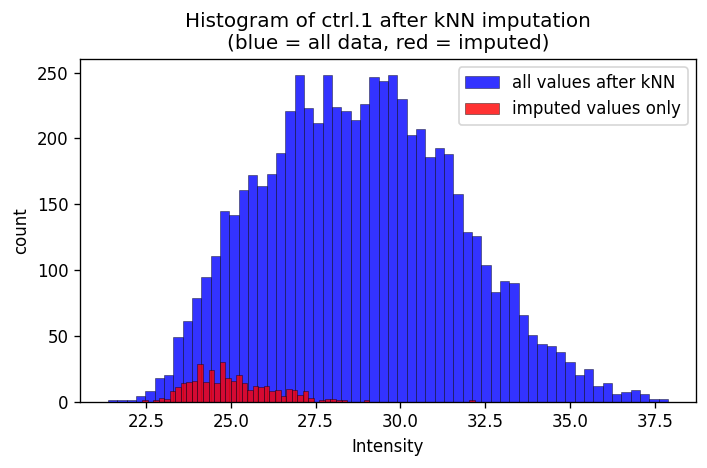


[metrics – kNN]
  method: knn
  total_values_after: 6733
  n_imputed: 360
  imputed_fraction: 0.05346799346502302
  mean_after: 28.821870073636298
  std_after_sample: 2.827167930240116
  orig_mean: 29.036041174810997
  orig_std_sample: 2.739044057746736
  n_neighbors: 9
  weights: distance


In [23]:
# --- kNN imputation summary for ctrl.1 WITH comparison-ready metrics ---

# values for ctrl.1 after kNN (kept rows only)
ctrl1_all = imputed_ctrl_df["ctrl.1"].astype(float)
ctrl1_imputed_only = imputed_ctrl_df.loc[ctrl1_na_mask, "ctrl.1"].astype(float)

# stats
n_total = ctrl1_all.shape[0]
n_imputed = ctrl1_imputed_only.shape[0]
mean_after = ctrl1_all.mean()
std_after = ctrl1_all.std(ddof=1)

print("ctrl.1 after kNN imputation:")
print(f"  total values (kept rows): {n_total}")
print(f"  imputed values: {n_imputed}")
print(f"  mean: {mean_after:.4f}")
print(f"  std (sample): {std_after:.4f}")

# ensure hist_bins exists
try:
    hist_bins
except NameError:
    hist_bins = 60

# plot (match style of the reference cell)
plt.figure(figsize=(6,4))

# all values after kNN (blue)
plt.hist(
    ctrl1_all,
    bins=hist_bins,
    alpha=0.8,
    color="blue",
    edgecolor="black",
    linewidth=0.3,
    label="all values after kNN"
)

# imputed-only values (red), plotted on top
if n_imputed > 0:
    plt.hist(
        ctrl1_imputed_only,
        bins=hist_bins,
        alpha=0.8,
        color="red",
        edgecolor="black",
        linewidth=0.3,
        label="imputed values only"
    )

plt.xlabel("Intensity")
plt.ylabel("count")
plt.title("Histogram of ctrl.1 after kNN imputation\n(blue = all data, red = imputed)")
plt.legend()
plt.tight_layout()
knn_plot_path = "ctrl1_knn_imputation_hist.png"
plt.savefig(knn_plot_path, dpi=150, bbox_inches="tight")
plt.show()

# -------- comparison-ready metrics (kNN method) --------
# Original observed-only stats (use the same baseline column from the full dataset)
obs = ms_data["ctrl.1"].dropna()

# How many rows were dropped when requiring "not all three controls missing"?
try:
    n_rows_full = ms_data.shape[0]
    n_rows_kept = imputed_ctrl_df.shape[0]
    n_rows_dropped = n_rows_full - n_rows_kept
except Exception:
    n_rows_full = None
    n_rows_kept = None
    n_rows_dropped = None

metrics_ctrl1_knn = {
    "method": "knn",
    "scope": "kept_rows_only",
    "n_neighbors": int(n_neighbors),
    "weights": str(weights),

    # dataset scope info
    "n_rows_full": int(n_rows_full) if n_rows_full is not None else None,
    "n_rows_kept_for_knn": int(n_rows_kept) if n_rows_kept is not None else None,
    "n_rows_dropped_all_three_missing": int(n_rows_dropped) if n_rows_dropped is not None else None,

    # original observed-only stats (same baseline as distribution cell)
    "orig_nonmissing_n": int(obs.shape[0]),
    "orig_mean": float(obs.mean()),
    "orig_std_sample": float(obs.std(ddof=1)),

    # after-imputation (kept rows)
    "total_values_after": int(n_total),
    "n_imputed": int(n_imputed),
    "imputed_fraction": float(n_imputed / n_total if n_total else np.nan),
    "mean_after": float(mean_after),
    "std_after_sample": float(std_after),
    "min_after": float(np.min(ctrl1_all)),
    "max_after": float(np.max(ctrl1_all)),
    "p25_after": float(np.percentile(ctrl1_all, 25)),
    "p50_after": float(np.percentile(ctrl1_all, 50)),
    "p75_after": float(np.percentile(ctrl1_all, 75)),

    # outputs
    "histogram_path": knn_plot_path,
}

# print a compact preview
print("\n[metrics – kNN]")
for k in [
    "method","total_values_after","n_imputed","imputed_fraction",
    "mean_after","std_after_sample","orig_mean","orig_std_sample",
    "n_neighbors","weights"
]:
    print(f"  {k}: {metrics_ctrl1_knn[k]}")

# persist per-method metrics
pd.DataFrame([metrics_ctrl1_knn]).to_csv(
    "ctrl1_metrics_knn.csv", index=False
)


metrics_list = [metrics_ctrl1_knn]

# if a distribution metrics dict already exists in the list, also write a combined summary
if any(m.get("method") == "distribution" for m in metrics_list):
    pd.DataFrame(metrics_list).to_csv("ctrl1_metrics_summary.csv", index=False)
    print("\nSaved combined summary: ctrl1_metrics_summary.csv")


In [24]:
dist_csv = "./ctrl1_metrics_distribution.csv"
knn_csv = "./ctrl1_metrics_knn.csv"

# Read
dist = pd.read_csv(dist_csv)
knn = pd.read_csv(knn_csv)

# Force/standardize method labels
dist["method"] = "distribution"
knn["method"] = "knn"

keep_and_rename = {
    "method": "Method",
    "total_values_after": "Total",
    "n_imputed": "Imputed_N",
    "mean_after": "Mean",
    "std_after_sample": "Std"
}

dist_clean = dist[list(keep_and_rename.keys())].rename(columns=keep_and_rename)
knn_clean = knn[list(keep_and_rename.keys())].rename(columns=keep_and_rename)

# Combine
summary_min = pd.concat([dist_clean, knn_clean], ignore_index=True)

# Optional: sort by Method for readability
summary_min = summary_min.sort_values("Method").reset_index(drop=True)

# Round numeric columns (if present)
for col in ("Mean", "Std"):
    if col in summary_min.columns:
        summary_min[col] = summary_min[col].astype(float).round(4)

# Show and save
display(summary_min)
summary_min.to_csv("ctrl1_metrics_summary_min.csv", index=False)
print("Saved: ctrl1_metrics_summary_min.csv")


,Method,Total,Imputed_N,Mean,Std
0,distribution,6960,587,28.4971,3.1744
1,knn,6733,360,28.8219,2.8272


Saved: ctrl1_metrics_summary_min.csv


# kNN vs Distribution-Based Imputation: Comparison

### Performance Analysis

Comparing k-Nearest Neighbor imputation with distribution-based methods:
- Which method provides better accuracy?
- When should each method be preferred?
